# Introduction 💥
## ⏰ Last minute forecasting 📈
In this notebook, we will explore the data from the Playground Series S3E19 competition, which is about predicting the number of sales of different products in different countries and stores. We will use various libraries for data analysis, visualization, machine learning, and model evaluation. 

> Our goal is to achieve a low SMAPE score, which is the metric used for scoring this competition. 🎯

We will be using scikit-learn pipelines, one-hot and ordinal encoders, standard scaler and CatBoost regressor.

> With a **SMAPE score of 8.08..**. wait I joined the comp 6h ago, there is still room to improve ;)

Join me on this journey as we uncover insights and patterns that will help us understand what factors influence the sales of different products.

## We will go through
- Creating easy to use **data processing pipelines** using scikit-learn
- **Creative feature engineering** 💡
- Optimizing the model hyperparameters using **optuna**
- Evaluating the model performance using **SMAPE** score
- Interpreting the model results using feature importance and SHAP values

## Table of Contents
1. [Libraries 📖](#Libraries-📖)
2. [Load data 📂](#Load-data-📁)
3. [Data analysis 📊](#Data-analysis-📊)
4. [Feature engineering 🛠️](#Feature-engineering-🛠️)
    1. [Fix virus year](#Fix-virus-year)
    2. [Split date](#Split-date)
    3. [Weekends](#Weekends)
    4. [Holidays](#Holidays)
    5. [Season](#Season)
    6. [Drop columns](#Drop-columns)
5. [Preprocessing ⚙️](#Preprocessing-⚙️)
    1. [Split](#Split)
    2. [Create a pipeline](#Create-a-pipeline)
        1. [Numerical columns](#Numerical-columns)
        2. [Categorical columns](#Categorical-columns)
6. [Modeling 🪄](#Modeling-🪄)
    1. [Metric](#Metric)
    2. [Hyperparameter optimization](#Hyperparameter-optimization)
    3. [Fitting model](#Fitting-model)
    4. [Model evaluation](#Model-evaluation)
    5. [SHAP values](#SHAP-values)
7. [Submission 🏆](#Submission-🏆)
    1. [Prediction visualization](#Prediction-visualization)
8. [Thank you ✨](#Thank-you-✨)





I know I’m late to the party, but I hope you find this notebook useful and interesting. 

# Libraries 📖
***

In [1]:
# Other
from datetime import datetime

# Holy grail
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameter optimization library
import optuna

# Machine learning model
from catboost import CatBoostRegressor

# SHAP values
import shap

# Random state
rs = 2137

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load data 📁
***

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e19/train.csv', index_col='id', parse_dates=['date'], date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))
train.head()

,date,country,store,product,num_sold
id,,,,,
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


# Data analysis 📊
***

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136950 entries, 0 to 136949
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      136950 non-null  datetime64[ns]
 1   country   136950 non-null  object        
 2   store     136950 non-null  object        
 3   product   136950 non-null  object        
 4   num_sold  136950 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 6.3+ MB


In [4]:
# Number of missing values in each column
train.isnull().sum()

date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

<div style="border-radius: 10px; border: #00d65c solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>✅ Great :</b> There are no missing values!
</div>

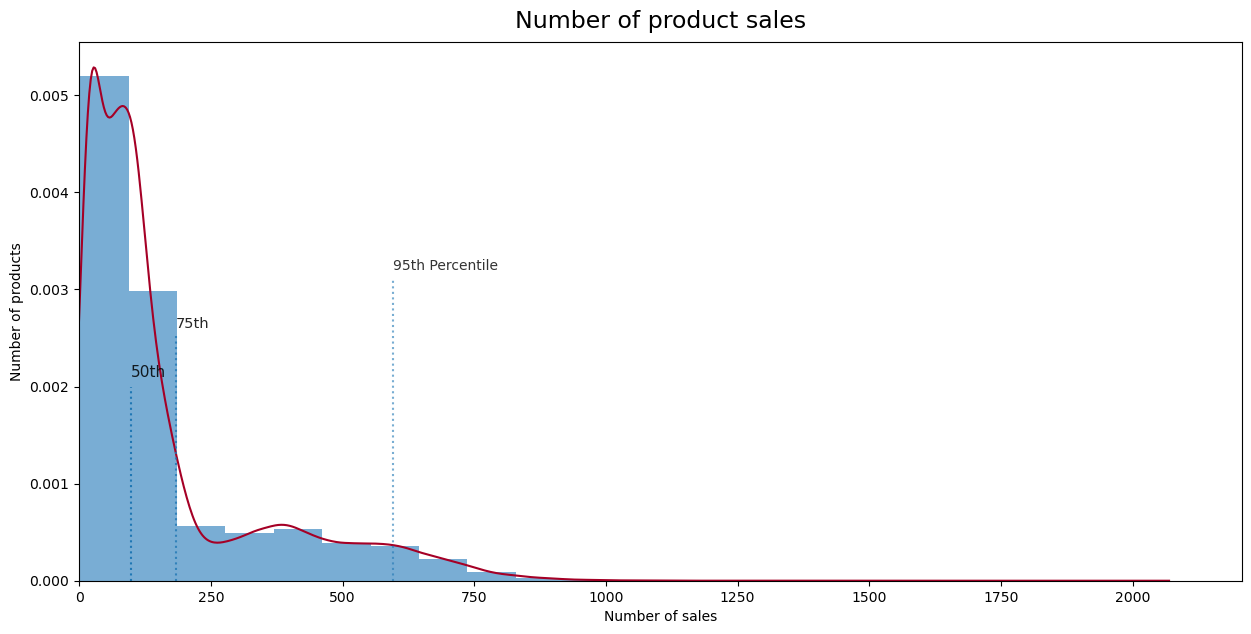

In [5]:
# Plot
train['num_sold'].plot(kind = "hist", density = True, alpha = 0.65, bins = 15, colormap='tab20c', figsize=(15,10)) # change density to true, because KDE uses density
train['num_sold'].plot(kind = "kde", colormap='RdYlBu', figsize=(15,7))

# Quantile lines
quant_50, quant_75, quant_95 = train['num_sold'].quantile(0.5), train['num_sold'].quantile(0.75), train['num_sold'].quantile(0.95)
quants = [[quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]
for i in quants:
    plt.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

# X
plt.xlabel('Number of sales')
plt.xlim(0)

# Y
plt.ylabel('Number of products')

# # Annotations
plt.text(quant_50-.13, .0021, "50th", size = 11, alpha = .85)
plt.text(quant_75-.13, .0026, "75th", size = 10.5, alpha = .85)
plt.text(quant_95-.25, .0032, "95th Percentile", size = 10, alpha =.8)

# # Overall
plt.title("Number of product sales", size = 17, pad = 10)
    
plt.show()

<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📉 Observation :</b> We can see that over 75% of products sell in quantities under around 200.
</div>

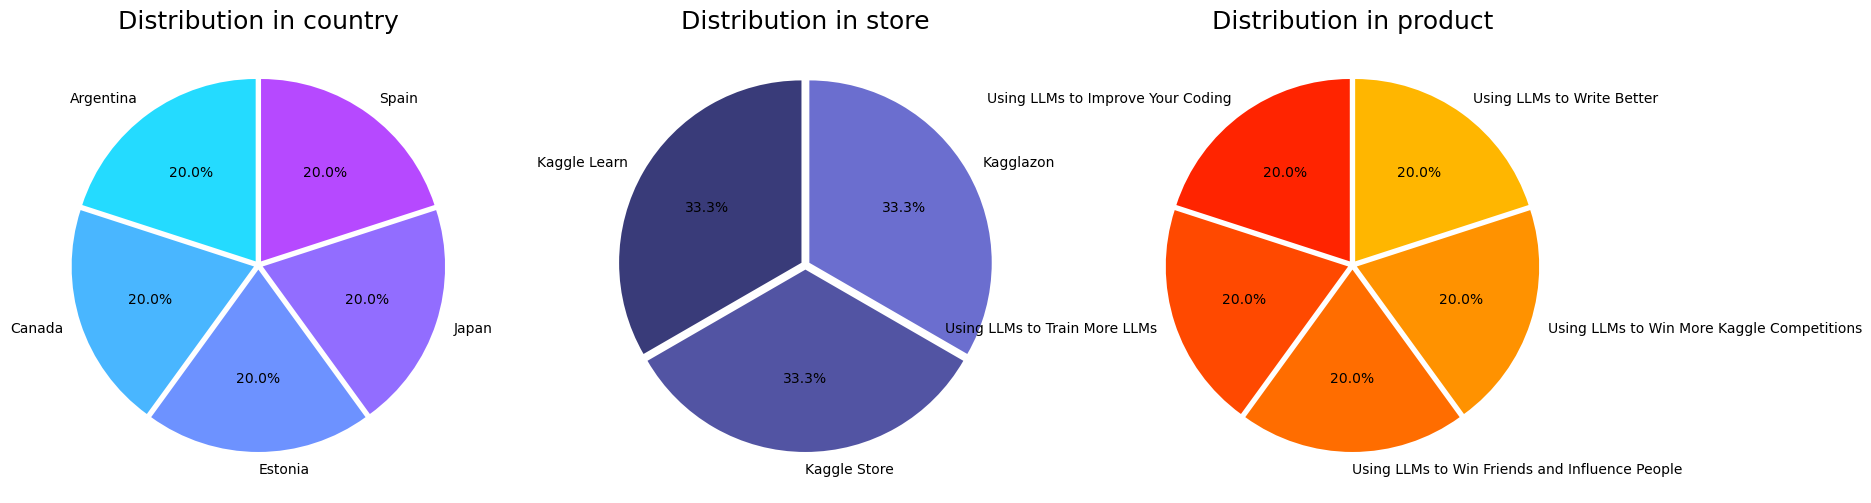

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

for i, col in enumerate(['country', 'store', 'product']):
    axs[i].pie(
        train[col].value_counts(),
        labels=train[col].unique(),
        explode=[.025]*len(train[col].unique()), 
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette(['cool', 'tab20b', 'autumn'][i])
    )
    
    axs[i].set_title(f'Distribution in {col}', size=18)

plt.show()

<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> 📉 Note :</b> Categorical column seem to be evenly distributed. That's interesting... 🤔
</div>

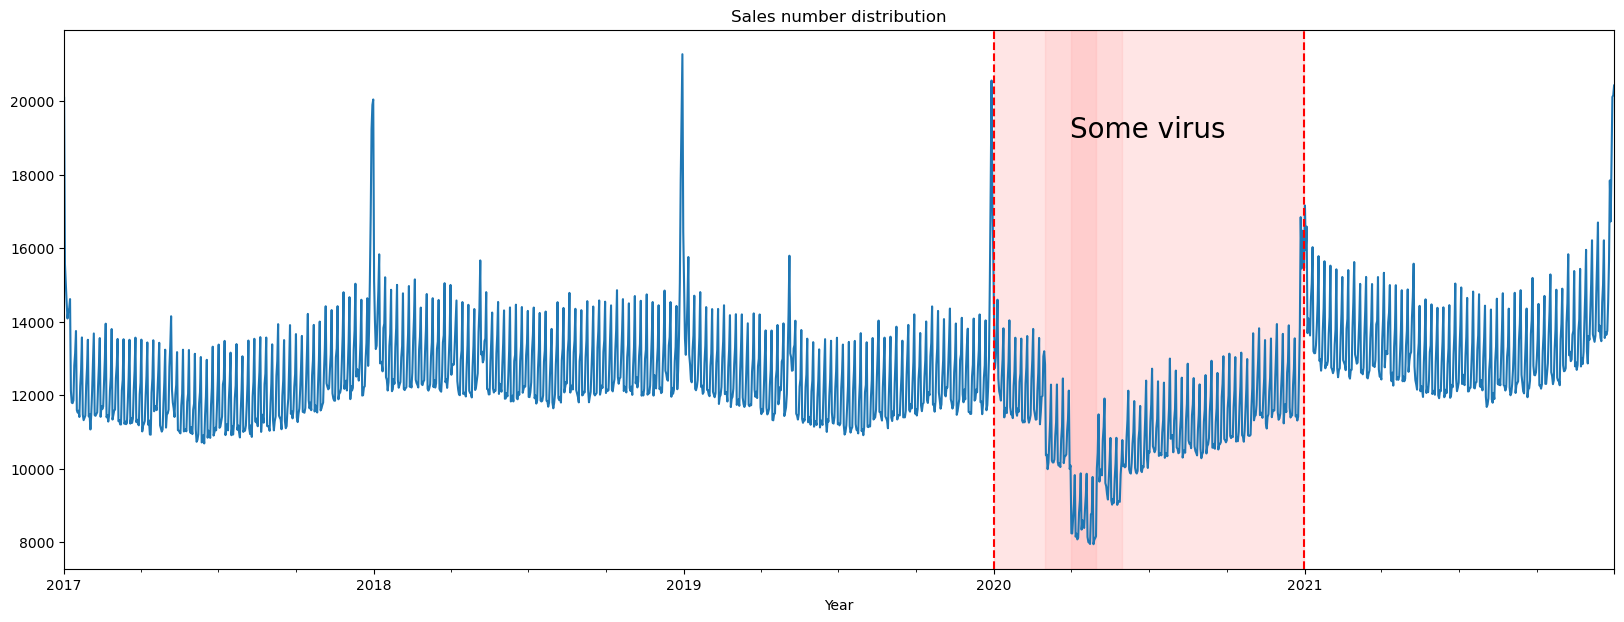

In [7]:
train.groupby('date')['num_sold'].sum().plot(kind='line', title='Sales number distribution', figsize=(20, 7), xlabel='Year')
plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-12-31'), color='red', alpha=0.1)
plt.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-5-31'), color='red', alpha=0.05)
plt.axvspan(pd.Timestamp('2020-04-01'), pd.Timestamp('2020-04-30'), color='red', alpha=0.05)
plt.text(pd.Timestamp ('2020-03-30'), 19000, "Some virus", size = 20)
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "--", color='red')
plt.axvline(pd.Timestamp('2020-12-31'), linestyle = "--", color='red')
plt.show()

<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> 🦠 Note :</b> We can see stable and cyclic trends in a number of sales. Smaller jumps are propably weekends and bigger jumps are Christmas holidays. What is also important to note is that there is a <b>significant decrease in sales during 2020 - 2021 period</b>, thats propably due to some virus, so we will propably exclude that year from training because it is an outlier year ;)
</div>

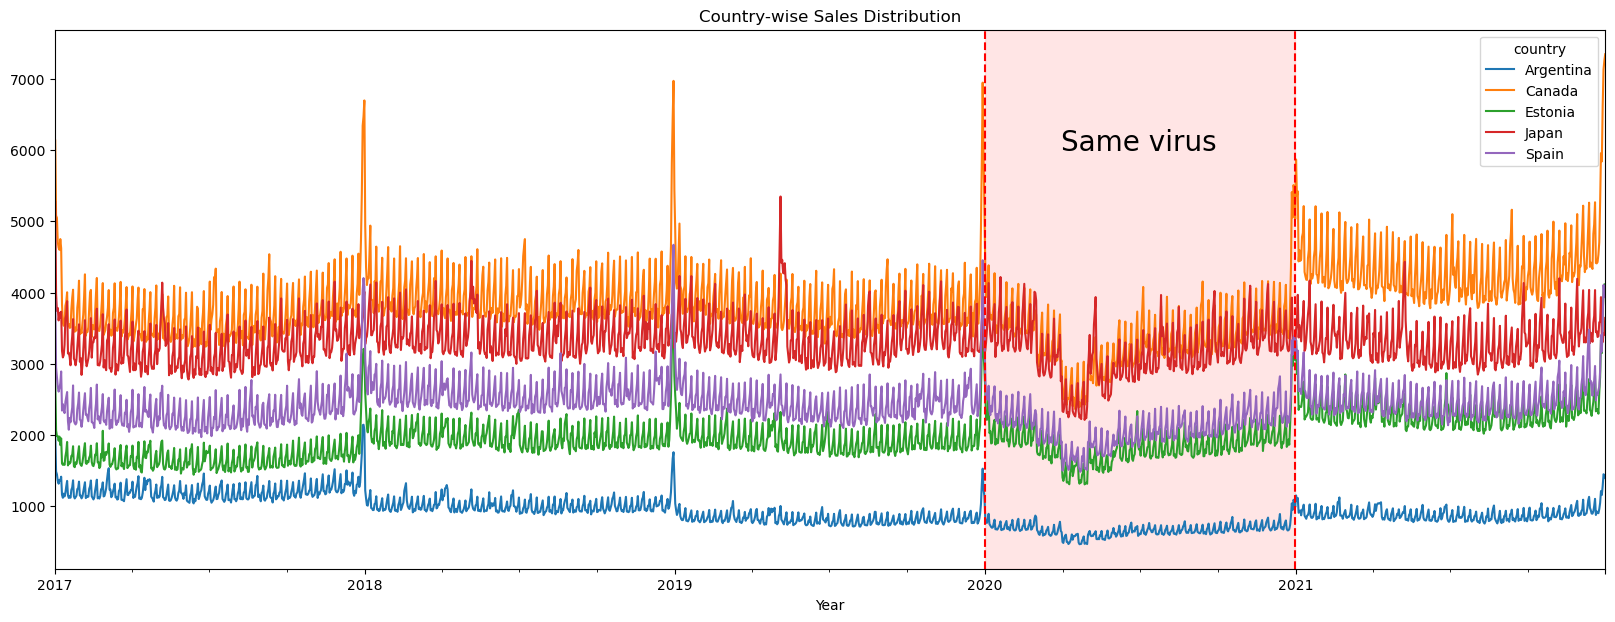

In [8]:
train.groupby(['date', 'country'])['num_sold'].sum().unstack().plot(kind='line', title='Country-wise Sales Distribution', figsize=(20, 7), xlabel='Year')
plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-12-31'), color='red', alpha=0.1)
plt.text(pd.Timestamp ('2020-03-30'), 6000, "Same virus", size = 20)
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "--", color='red')
plt.axvline(pd.Timestamp('2020-12-31'), linestyle = "--", color='red')
plt.show()

In [9]:
# Dataframe for visualization
train_plot = train.copy(deep=True)

train_plot['dayofweek'] = train_plot['date'].dt.dayofweek
train_plot['month'] = train_plot['date'].dt.month
train_plot['year'] = train_plot['date'].dt.year

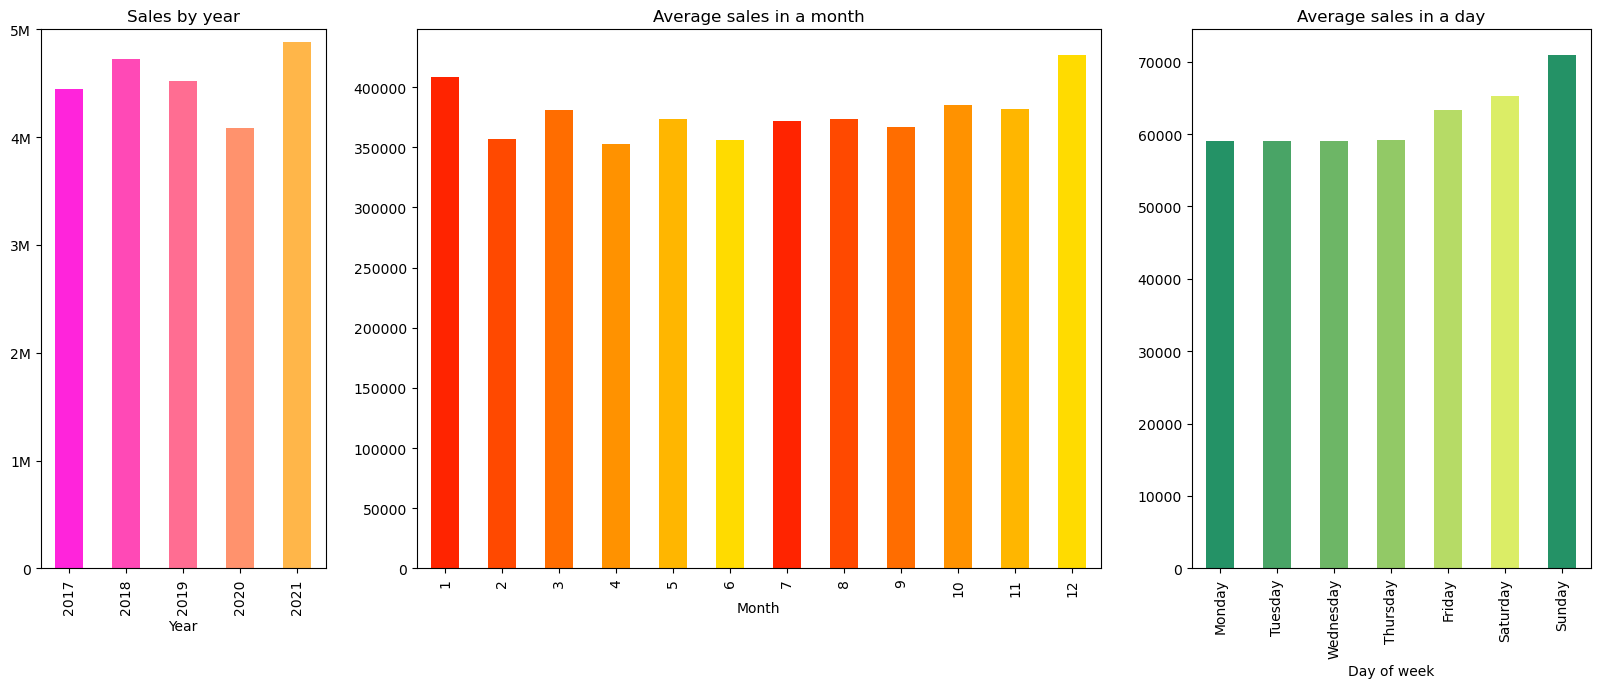

In [10]:
import calendar
fig, axs = plt.subplots(1, 3, width_ratios=[5, 12, 7], figsize=(20,7))

train_plot.groupby('year')['num_sold'].sum().plot(
    kind='bar',
    title='Sales by year',
    ylim=(0, 5000000),
    xlabel='Year',
    color=sns.color_palette('spring'),
    ax=axs[0]
)

avg_month = train_plot.groupby('month')['num_sold'].sum() / len(train_plot['year'].unique())
avg_month.plot(kind='bar', title='Average sales in a month', xlabel='Month', color=sns.color_palette('autumn'), ax=axs[1])

avg_week = train_plot.groupby('dayofweek')['num_sold'].sum() / 52
avg_week.plot(kind='bar', title='Average sales in a day', xlabel='Day of week', color=sns.color_palette('summer'), ax=axs[2])

axs[0].set_xticklabels([2017, 2018, 2019, 2020, 2021])
axs[0].set_yticks(list(range(0, 6000000, 1000000)), ['0', '1M', '2M', '3M', '4M', '5M'])
axs[2].set_xticks(ticks=range(7), labels=calendar.day_name)

plt.xticks(rotation = 90)
plt.show()

<div class="warning" style="background-color: #DDE6ED; border-left: 6px solid #27374D; font-size: 100%; padding: 10px;">
    <h3 style="color: #27374D; font-size: 18px; margin-top: 0; margin-bottom: 10px;">🔎  Observations</h3>
    <ul>
        <li>Covid year had almost 20% less sales than 2021 year and 8/9 sales of 2019.</li>
        <li>Also most sales are in the January and December.</li>
        <li>From Friday to Sunday there is a increase of sales.</li>
    </ul>
</div>

In [11]:
# Let's see what and how many stores are in each country
train[['country', 'store']].value_counts()

country    store       
Argentina  Kagglazon       9130
           Kaggle Learn    9130
           Kaggle Store    9130
Canada     Kagglazon       9130
           Kaggle Learn    9130
           Kaggle Store    9130
Estonia    Kagglazon       9130
           Kaggle Learn    9130
           Kaggle Store    9130
Japan      Kagglazon       9130
           Kaggle Learn    9130
           Kaggle Store    9130
Spain      Kagglazon       9130
           Kaggle Learn    9130
           Kaggle Store    9130
dtype: int64

In [12]:
# Let's see what and how many products are in each store
train[['store', 'product']].value_counts()

store         product                                       
Kagglazon     Using LLMs to Improve Your Coding                 9130
              Using LLMs to Train More LLMs                     9130
              Using LLMs to Win Friends and Influence People    9130
              Using LLMs to Win More Kaggle Competitions        9130
              Using LLMs to Write Better                        9130
Kaggle Learn  Using LLMs to Improve Your Coding                 9130
              Using LLMs to Train More LLMs                     9130
              Using LLMs to Win Friends and Influence People    9130
              Using LLMs to Win More Kaggle Competitions        9130
              Using LLMs to Write Better                        9130
Kaggle Store  Using LLMs to Improve Your Coding                 9130
              Using LLMs to Train More LLMs                     9130
              Using LLMs to Win Friends and Influence People    9130
              Using LLMs to Win More Kaggl

In [13]:
# Let's see what and how many products are in each country
train[['country', 'product']].value_counts()

country    product                                       
Argentina  Using LLMs to Improve Your Coding                 5478
Estonia    Using LLMs to Win More Kaggle Competitions        5478
Spain      Using LLMs to Win More Kaggle Competitions        5478
           Using LLMs to Win Friends and Influence People    5478
           Using LLMs to Train More LLMs                     5478
           Using LLMs to Improve Your Coding                 5478
Japan      Using LLMs to Write Better                        5478
           Using LLMs to Win More Kaggle Competitions        5478
           Using LLMs to Win Friends and Influence People    5478
           Using LLMs to Train More LLMs                     5478
           Using LLMs to Improve Your Coding                 5478
Estonia    Using LLMs to Write Better                        5478
           Using LLMs to Win Friends and Influence People    5478
Argentina  Using LLMs to Train More LLMs                     5478
Estonia    Using L

<div class="warning" style="background-color: #DDE6ED; border-left: 6px solid #27374D; font-size: 100%; padding: 10px;">
    <h3 style="color: #27374D; font-size: 18px; margin-top: 0; margin-bottom: 10px;">🔎  Observations:</h3>
    <ul>
        <li>Each country has every store is equal quantities.</li>
        <li>Each store chain has all products that sell in equal quantities.</li>
        <li>But <b>not all countries have the same products</b> so stores (nationwide) have different products but they also sell in the same quantities.</li>
    </ul>
</div>

# Feature engineering 🛠️
***

## Split date
Let's split date to `day`, `dayofweek`, `week`, `month` and `year` and then use those features to create **cyclic** versions of those.

In [14]:
train['day'] = train['date'].dt.day
train['dayofweek'] = train['date'].dt.dayofweek 
train['week'] = train['date'].dt.isocalendar().week
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

## Fix virus year
This year may couse a lot of overfitting. In some sense 2020 it is an outlier because of its sales distribution so we will fix it by making it similar to neighbouring years.

In [15]:
# Calculate the average monthly sales for non-virus years (2019 and 2021)
avg_sales_non_virus = train[train['year'].isin((2019,2021))].groupby('month')['num_sold'].mean()

# Calculate the average monthly for virus year (2020)
avg_sales_virus = train[train['year'] == 2020].groupby('month')['num_sold'].mean()

# Calculate the ratios for each month
ratios_for_months = avg_sales_non_virus/avg_sales_virus

# Multiply the num_sold column for each row in 2020 by the corresponding ratio for the month of that row
train.loc[train['year'] == 2020, 'num_sold'] *= train['month'].map(ratios_for_months)

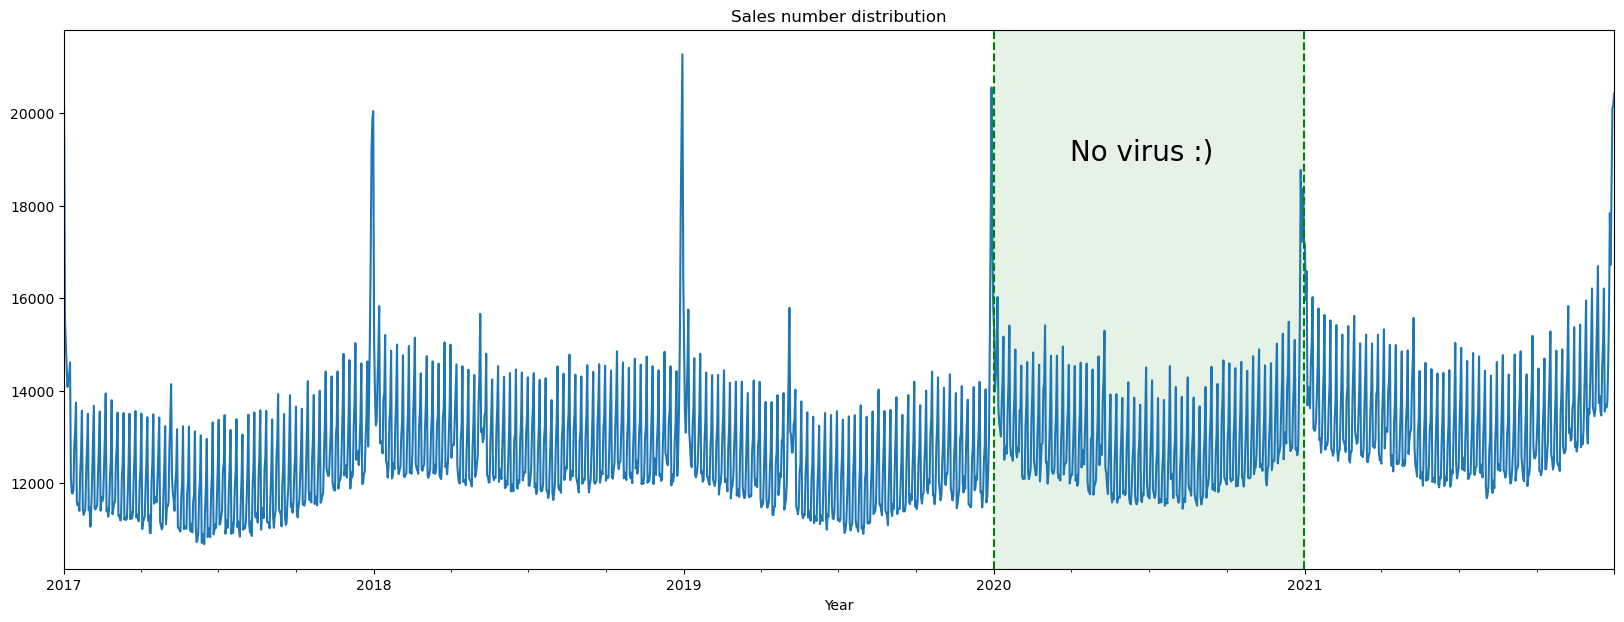

In [16]:
train.groupby('date')['num_sold'].sum().plot(kind='line', title='Sales number distribution', figsize=(20, 7), xlabel='Year')
plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-12-31'), color='green', alpha=0.1)
plt.text(pd.Timestamp ('2020-03-30'), 19000, "No virus :)", size = 20)
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "--", color='green')
plt.axvline(pd.Timestamp('2020-12-31'), linestyle = "--", color='green')
plt.show()                                              

<div style="border-radius: 10px; border: #00d65c solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>✅ Great :</b> There was no pandemic! 😯
</div>

<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> 🗓️ Cyclic nature of time :</b> In all the cases, but Year, the features should be split into two parts: sinus and cosine, to reflect cyclicity, e.g. the 1st January is near the 31st December.
</div>

In [17]:
train['day_sin'] = np.sin(2 * np.pi * train['day']/31)
train['day_cos'] = np.cos(2 * np.pi * train['day']/31)

train['dayofweek_sin'] = np.sin(2 * np.pi * train['dayofweek']/6) # indexed [0, 6]
train['dayofweek_cos'] = np.cos(2 * np.pi * train['dayofweek']/6)

train['week_sin'] = np.sin(2 * np.pi * train['week']/52)
train['week_cos'] = np.cos(2 * np.pi * train['week']/52)

train['month_sin'] = np.sin(2 * np.pi * train['month']/12)
train['month_cos'] = np.cos(2 * np.pi * train['month']/12)

<div style="border-radius: 10px; border: #ffac00 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> ⚠️ Year as feature :</b> I'm not sure about making year a feature because we will be using our model to predict future and our model will be used to predict entire 2022. But in 2021 there has been more sales so this trend propably will stay in the start of 2022. So year may be useful.
</div>

## Weekends
We can create additional features baseod on `dayofweek`.

In [18]:
train["is_weekend"] = train['dayofweek'].isin([4, 5, 6]).astype(int)
train["is_sunday"] = train['dayofweek'].eq(6).astype(int)

## Holidays
Let's create boolean collumn `holiday`. From previous charts we saw that national holidays affect sales.

In [19]:
import holidays

years_list = [2017, 2018, 2019, 2020, 2021, 2022]
holiday_cols = ['AR_holiday', 'CA_holiday', 'EE_holiday', 'JP_holiday', 'ES_holiday']

AR_holidays = holidays.CountryHoliday('AR', years=years_list)
CA_holidays = holidays.CountryHoliday('CA', years=years_list)
EE_holidays = holidays.CountryHoliday('EE', years=years_list)
JP_holidays = holidays.CountryHoliday('JP', years=years_list)
ES_holidays = holidays.CountryHoliday('ES', years=years_list)

# Create Holiday Column 
train['AR_holiday'] = train.loc[train['country'] == 'Argentina', 'date'].apply(lambda d: d in AR_holidays)
train['CA_holiday'] = train.loc[train['country'] == 'Canada', 'date'].apply(lambda d: d in CA_holidays)
train['EE_holiday'] = train.loc[train['country'] == 'Estonia', 'date'].apply(lambda d: d in EE_holidays)
train['JP_holiday'] = train.loc[train['country'] == 'Japan', 'date'].apply(lambda d: d in JP_holidays)
train['ES_holiday'] = train.loc[train['country'] == 'Spain', 'date'].apply(lambda d: d in ES_holidays)

train = train.fillna('')

train['holiday'] = train['AR_holiday'].astype('str') + train['CA_holiday'].astype('str') \
                + train['EE_holiday'].astype('str') + train['JP_holiday'].astype('str') \
                + train['ES_holiday'].astype('str')

## Season
Season also affects number of sales.

In [20]:
# Create Season Column, Spring = 1, Summer = 2, Autumn = 3, Winter = 4
AR_seasons = np.array([2, 2, 3, 3, 3, 4, 4, 4, 1, 1, 1, 2]).astype(int)
AR_seasons_dict = dict(zip(range(1, 13), AR_seasons))

other_seasons = np.array([4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4]).astype(int)
other_seasons_dict = dict(zip(range(1, 13), other_seasons))

train['AR_season'] = train.loc[train['country'] == 'Argentina', 'month'].map(AR_seasons_dict)
train['season'] = train.loc[train['country'] != 'Argentina', 'month'].map(other_seasons_dict)
train['season'] = train['season'].fillna(train['AR_season'])

## Drop columns
Now we can drop columns from which we have extracted necessary information

In [21]:
train.drop(columns=['date', 'day', 'dayofweek', 'week', 'month', 'AR_season'] + holiday_cols, inplace=True)

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136950 entries, 0 to 136949
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   country        136950 non-null  object 
 1   store          136950 non-null  object 
 2   product        136950 non-null  object 
 3   num_sold       136950 non-null  float64
 4   year           136950 non-null  int64  
 5   day_sin        136950 non-null  float64
 6   day_cos        136950 non-null  float64
 7   dayofweek_sin  136950 non-null  float64
 8   dayofweek_cos  136950 non-null  float64
 9   week_sin       136950 non-null  Float64
 10  week_cos       136950 non-null  Float64
 11  month_sin      136950 non-null  float64
 12  month_cos      136950 non-null  float64
 13  is_weekend     136950 non-null  int64  
 14  is_sunday      136950 non-null  int64  
 15  holiday        136950 non-null  object 
 16  season         136950 non-null  float64
dtypes: Float64(2), float64(8), in

# Preprocessing ⚙️
***

## Split
**Split `train` dataframe to `X` and `y` dataframes**

In [23]:
X = train.drop(columns=['num_sold'], inplace=False)
y = train['num_sold'].astype(int)

## Create a pipeline
### Numerical columns
- I won't apply any transformers because those columns already are sine and cosine functions with values from -1 to 1 and even distributions

### Categorical columns
- `OneHotEncoder()` one-hot encodes the data

In [24]:
column_transformer = make_column_transformer(
    # Numerical columns
    (
        StandardScaler(),
        ['year', 'day_sin', 'day_cos', 'dayofweek_sin', 'dayofweek_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos'] # I'm not using make_column_selector for numeric because of 'is_holiday', 'is_weekend', 'is_sunday'
    ),
    # Categorical columns
    (
        OneHotEncoder(handle_unknown='ignore', drop='first'),
        make_column_selector(dtype_include='object')
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [25]:
X_transformed = column_transformer.fit_transform(X)

In [26]:
column_transformer.get_feature_names_out().tolist()

['year',
 'day_sin',
 'day_cos',
 'dayofweek_sin',
 'dayofweek_cos',
 'week_sin',
 'week_cos',
 'month_sin',
 'month_cos',
 'country_Canada',
 'country_Estonia',
 'country_Japan',
 'country_Spain',
 'store_Kaggle Learn',
 'store_Kaggle Store',
 'product_Using LLMs to Train More LLMs',
 'product_Using LLMs to Win Friends and Influence People',
 'product_Using LLMs to Win More Kaggle Competitions',
 'product_Using LLMs to Write Better',
 'holiday_True',
 'is_weekend',
 'is_sunday',
 'season']

In [27]:
X_transformed = pd.DataFrame(data=X_transformed, columns=column_transformer.get_feature_names_out().tolist())
X_transformed.sample(5)

,year,day_sin,day_cos,dayofweek_sin,dayofweek_cos,week_sin,week_cos,month_sin,month_cos,country_Canada,...,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better,holiday_True,is_weekend,is_sunday,season
52778,-0.707591,1.187691,0.781289,1.322423,-0.865580,-0.502940,1.315633,0.006949,1.414478,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0
12628,-1.414795,-0.682306,-1.221799,-0.000725,1.154721,0.338327,-1.375559,0.006949,-1.408556,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0
41498,-0.707591,1.398070,-0.046052,-0.000725,1.154721,-0.171390,-1.406294,-0.701535,-1.219449,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0
121634,1.414020,1.256606,-0.602375,-0.000725,-1.539013,0.501631,-1.324833,0.006949,-1.408556,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
44283,-0.707591,0.417679,-1.335695,1.322423,0.481287,-1.060893,-0.940922,-1.220180,-0.702798,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0


In [28]:
X_transformed.describe()

,year,day_sin,day_cos,dayofweek_sin,dayofweek_cos,week_sin,week_cos,month_sin,month_cos,country_Canada,...,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better,holiday_True,is_weekend,is_sunday,season
count,1.369500e+05,1.369500e+05,1.369500e+05,1.369500e+05,1.369500e+05,1.369500e+05,1.369500e+05,1.369500e+05,1.369500e+05,136950.000000,...,136950.000000,136950.000000,136950.000000,136950.000000,136950.000000,136950.000000,136950.000000,136950.000000,136950.000000,136950.000000
mean,-7.325102e-14,-2.158348e-17,3.818616e-17,-1.930061e-17,-6.620318e-17,6.641071e-18,4.648750e-17,2.324375e-17,1.128982e-16,0.200000,...,0.333333,0.333333,0.200000,0.200000,0.200000,0.200000,0.038992,0.428258,0.142935,2.494304
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.400001,...,0.471406,0.471406,0.400001,0.400001,0.400001,0.400001,0.193577,0.494828,0.350008,1.117436
min,-1.414795e+00,-1.402037e+00,-1.393833e+00,-1.323872e+00,-1.539013e+00,-1.417118e+00,-1.416589e+00,-1.410018e+00,-1.408556e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,-7.075910e-01,-1.018036e+00,-1.056808e+00,-1.323872e+00,-8.655798e-01,-9.399438e-01,-9.409221e-01,-1.220180e+00,-1.219449e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,-3.872966e-04,-1.983718e-03,-4.605199e-02,-7.246154e-04,4.812875e-01,-6.545186e-04,-4.600148e-03,6.948631e-03,2.960728e-03,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,7.068164e-01,1.014069e+00,1.009677e+00,1.322423e+00,1.154721e+00,9.386348e-01,1.052289e+00,7.154318e-01,1.225370e+00,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000
max,1.414020e+00,1.398070e+00,1.453646e+00,1.322423e+00,1.154721e+00,1.415809e+00,1.407389e+00,1.423915e+00,1.414478e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


<div style="border-radius: 10px; border: #00d65c solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> ✅ Great :</b> Now columns have zero mean and standard deviation equal to 1 so the model will learng faster and more efficient.
</div>

# Modeling 🪄
***
In this almost final section we will:

1. Split the dataset to training and validation sets
2. Create SMAPE evaluation function
2. Find the best hyperparatemers using optuna
3. Fit the CatBoosRegressor using those hyperparapeters
4. Evaluate model using SMAPE
5. Investigate model using SHAP values

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_transformed, y, train_size=0.95, random_state=rs)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(130102, 23) (130102,)
(6848, 23) (6848,)


<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> ✂️ Spliting:</b> I decided to assign <b>only 5%</b> of data to validation beacause our training set is very large and we still will have <b>over a thoused examples</b> to validate our model on.
</div>

## Metric
To evaluate our model we will use SMAPE score as it is used for scoring this competition submissions.

In [30]:
def SMAPE(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

## Hyperparameter optimization

In [31]:
def objective(trial):
    model=CatBoostRegressor(
        iterations = trial.suggest_int('iterations', 100, 300),
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3),
        depth = trial.suggest_int('depth', 1, 10), # depth above 10 usually introduces overfitting
        l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.2, 10),
        early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 1, 20),
        loss_function='RMSE',
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[( X_train, y_train), ( X_val, y_val)],
        verbose=False
    )

    return SMAPE(y_val, np.round(model.predict(X_val)))

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# best_hyperparams = study.best_params

In [32]:
best_hyperparams = {'iterations': 282, 'learning_rate': 0.09783414836979615, 'depth': 10, 'l2_leaf_reg': 6.888098846099011, 'early_stopping_rounds': 12}

## Fitting model

In [33]:
model = CatBoostRegressor(**best_hyperparams)

model.fit(
    X_train, y_train,
    eval_set=[( X_train, y_train), ( X_val, y_val)],
    verbose=False
)

## Model evaluation
Let's evaluate our model using method used for scoring in this competition.

In [34]:
print('Train score:', SMAPE(y_train, np.round(model.predict(X_train))))
print('Validation score:', SMAPE(y_val, np.round(model.predict(X_val))))

Train score: 4.753136212677497
Validation score: 5.059146314026002


<div style="border-radius: 10px; border: #00d65c solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> ✅ Great :</b> Out model has high score on both training and validation. There doesn't seem to be any issue with bias and overfitting.
</div>

## SHAP values
**SHAP (SHapley Additive exPlanations)** values are a way of explaining the predictions of a machine learning model. They measure how much each feature contributes to the prediction, either positively or negatively.

In [35]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

<div class="warning" style="background-color: #DDE6ED; border-left: 6px solid #27374D; font-size: 100%; padding: 10px;">
    <h3 style="color: #27374D; font-size: 18px; margin-top: 0; margin-bottom: 10px;">🔎  Interpretation</h3>
    This specific SHAP chart isn't really readable but still I got some insights:
    <ul>
        <li><b>Year</b> feature has highest negaive impact on our predictions</li>
        <li><b>Day of week</b> and <b>week</b> have one of the highest positive impacts on output predictions (can't see others 😑)</li>
    </ul>
    If you would like to see proper SHAP chart here is my <a href="https://www.kaggle.com/code/kacperrabczewski/spaceship-titanic-a-machine-learning-journey">Spaceship Titanic notebook</a>
</div>

<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> ❓ SHAP with regression:</b> A positive SHAP value for a feature means that the feature has a positive impact on the prediction, leading the model to predict a higher value. A negative SHAP value for a feature means that the feature has a negative impact on the prediction, leading the model to predict a lower value.
</div>

# Submission 🏆
***
Now we can apply every transformation on a test set step by step like we did on a training set.

In [36]:
X_test = pd.read_csv('/kaggle/input/playground-series-s3e19/test.csv', index_col='id', parse_dates=['date'], date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))

# Save for later, this is a suprise ;)
test_countries = X_test[['country']]

# Date features
X_test['day'] = X_test['date'].dt.day
X_test['dayofweek'] = X_test['date'].dt.dayofweek 
X_test['week'] = X_test['date'].dt.isocalendar().week
X_test['month'] = X_test['date'].dt.month
X_test['year'] = X_test['date'].dt.year

# Cyclic features
X_test['day_sin'] = np.sin(2 * np.pi * X_test['day']/31)
X_test['day_cos'] = np.cos(2 * np.pi * X_test['day']/31)

X_test['dayofweek_sin'] = np.sin(2 * np.pi * X_test['dayofweek']/6)
X_test['dayofweek_cos'] = np.cos(2 * np.pi * X_test['dayofweek']/6)

X_test['week_sin'] = np.sin(2 * np.pi * X_test['week']/52)
X_test['week_cos'] = np.cos(2 * np.pi * X_test['week']/52)

X_test['month_sin'] = np.sin(2 * np.pi * X_test['month']/12)
X_test['month_cos'] = np.cos(2 * np.pi * X_test['month']/12)

# Weekends and Sundays
X_test["is_weekend"] = X_test['dayofweek'].isin([4, 5, 6]).astype(int)
X_test["is_sunday"] = X_test['dayofweek'].eq(6).astype(int)

# Holidays 
X_test['AR_holiday'] = X_test.loc[X_test['country'] == 'Argentina', 'date'].apply(lambda d: d in AR_holidays)
X_test['CA_holiday'] = X_test.loc[X_test['country'] == 'Canada', 'date'].apply(lambda d: d in CA_holidays)
X_test['EE_holiday'] = X_test.loc[X_test['country'] == 'Estonia', 'date'].apply(lambda d: d in EE_holidays)
X_test['JP_holiday'] = X_test.loc[X_test['country'] == 'Japan', 'date'].apply(lambda d: d in JP_holidays)
X_test['ES_holiday'] = X_test.loc[X_test['country'] == 'Spain', 'date'].apply(lambda d: d in ES_holidays)
train = train.fillna('')

X_test['holiday'] = X_test['AR_holiday'].astype('str') + X_test['CA_holiday'].astype('str') + X_test['EE_holiday'].astype('str') + X_test['JP_holiday'].astype('str') + X_test['ES_holiday'].astype('str')

# Season
X_test['AR_season'] = X_test.loc[X_test['country'] == 'Argentina', 'month'].map(AR_seasons_dict)
X_test['season'] = X_test.loc[X_test['country'] != 'Argentina', 'month'].map(other_seasons_dict)
X_test['season'] = X_test['season'].fillna(X_test['AR_season'])

# Drop unnecessary columns
X_test.drop(columns=['date', 'day', 'dayofweek', 'week', 'month', 'AR_season'] + holiday_cols, inplace=True)

# Transformer
X_test = column_transformer.transform(X_test)

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros


In [37]:
# Make prediction and save it as a column in test copy
test_countries['num_sold'] = np.round(model.predict(X_test))
test_countries.head()

,country,num_sold
id,,
136950,Argentina,46.0
136951,Argentina,43.0
136952,Argentina,13.0
136953,Argentina,42.0
136954,Argentina,32.0


In [38]:
# Get ratios for every country (make average sales distribution to be equal for all countries)
mean_by_country = test_countries.groupby('country')[['num_sold']].mean()
sum_mean_country = mean_by_country.sum()

ratios = (sum_mean_country*0.31)/mean_by_country
ratios

,num_sold
country,
Argentina,4.700479
Canada,0.956257
Estonia,1.777040
Japan,1.250588
Spain,1.653001


In [39]:
predictions = test_countries.apply(lambda x: x['num_sold'] * ratios.loc[x['country']], axis=1)
predictions.head()

,num_sold
id,
136950,216.222018
136951,202.120582
136952,61.106223
136953,197.420103
136954,150.415317


In [40]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e19/sample_submission.csv', index_col='id')
sample_submission['num_sold'] = predictions
sample_submission.to_csv('/kaggle/working/submission.csv')
sample_submission.head()

,num_sold
id,
136950,216.222018
136951,202.120582
136952,61.106223
136953,197.420103
136954,150.415317


## Prediction visualization

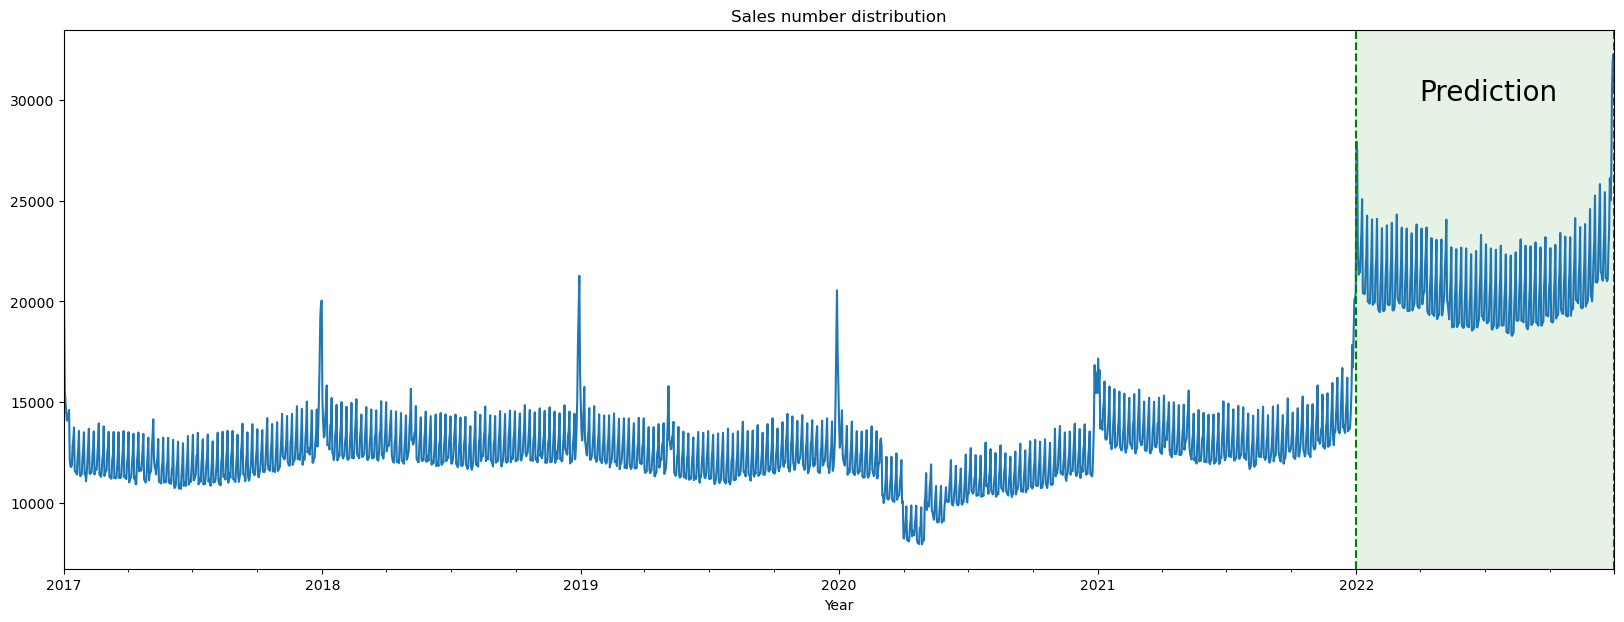

In [41]:
raw_test = pd.read_csv('/kaggle/input/playground-series-s3e19/test.csv', index_col='id', parse_dates=['date'], date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))
new_data = pd.DataFrame({'date': raw_test['date'], 'num_sold': predictions['num_sold']})

combined_data = pd.concat([train_plot, new_data])
grouped_data = combined_data.groupby('date')['num_sold'].sum()

# Plot the data
grouped_data.plot(kind='line', title='Sales number distribution', figsize=(20, 7), xlabel='Year')

plt.axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-12-31'), color='green', alpha=0.1)
plt.text(pd.Timestamp ('2022-03-30'), 30000, "Prediction", size = 20)
plt.axvline(pd.Timestamp('2022-01-01'), linestyle = "--", color='green')
plt.axvline(pd.Timestamp('2022-12-31'), linestyle = "--", color='green')

plt.show()

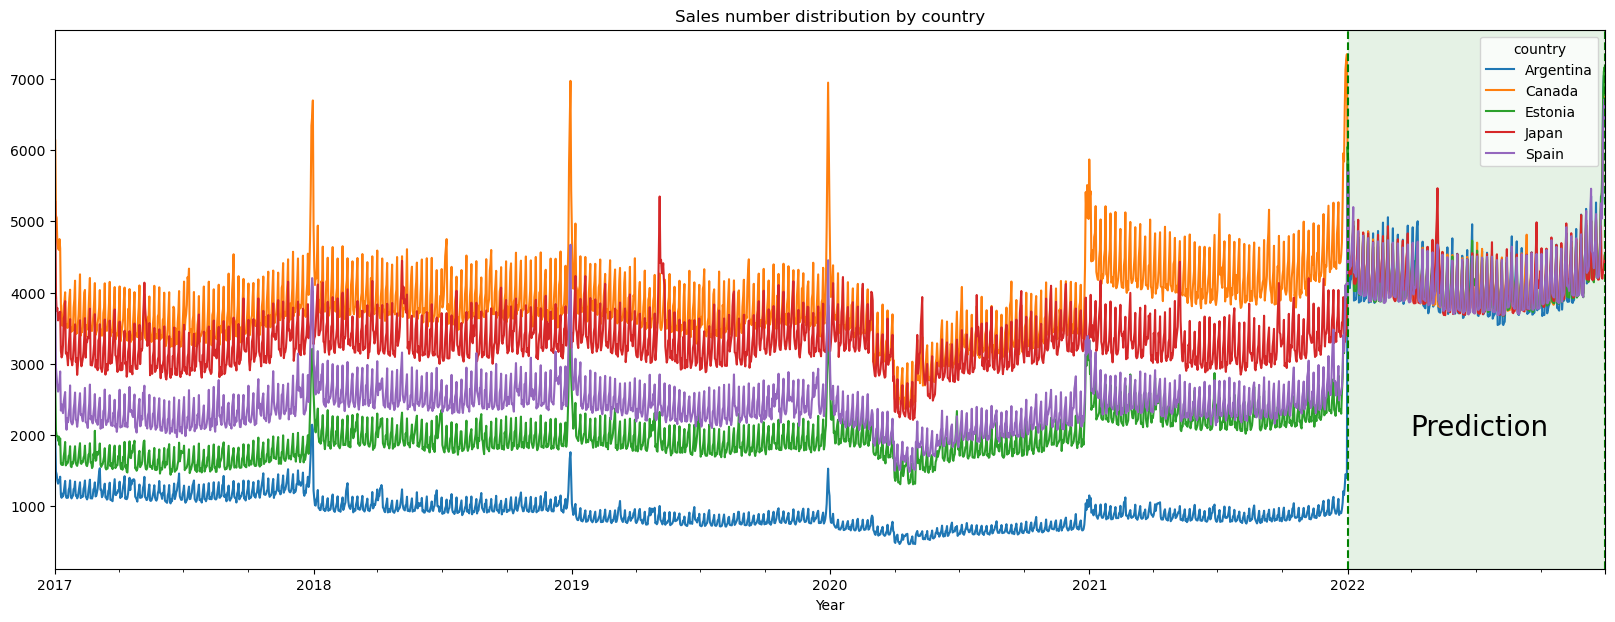

In [42]:
raw_test = pd.read_csv('/kaggle/input/playground-series-s3e19/test.csv', index_col='id', parse_dates=['date'], date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))
new_data = pd.DataFrame({'date': raw_test['date'], 'country': raw_test['country'],'num_sold': predictions['num_sold']})

combined_data = pd.concat([train_plot, new_data])
grouped_data = combined_data.groupby(['date', 'country'])['num_sold'].sum().unstack()

# Plot the data
grouped_data.plot(kind='line', title='Sales number distribution by country', figsize=(20, 7), xlabel='Year')

plt.axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-12-31'), color='green', alpha=0.1)
plt.text(pd.Timestamp ('2022-03-30'), 2000, "Prediction", size = 20)
plt.axvline(pd.Timestamp('2022-01-01'), linestyle = "--", color='green')
plt.axvline(pd.Timestamp('2022-12-31'), linestyle = "--", color='green')

plt.show()

# Thank you ✨

I hope you enjoyed this notebook and learned something new. 😊
If you did, please consider upvoting it and leaving a comment. I would love to hear your feedback and suggestions. 💬

Also, feel free to fork this notebook and experiment with different models, features, and techniques.

Thank you for reading and happy kaggling! 🚀